In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [7]:
cols = ['sentiment','id','date','query_string','user','text']
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding="ISO-8859-1", header=None, names=cols)

In [8]:
df.head()

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [9]:
df = df.drop(columns=["id", "date", "query_string", "user"])

In [10]:
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [12]:
X = df['text']
y = df['sentiment']

In [13]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Setting up the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('scaler', StandardScaler(with_mean=False)),  # Scaling is recommended for Logistic Regression
    ('clf', LogisticRegression(penalty='l1', solver='liblinear'))
])

In [15]:
# Training the pipeline
pipeline.fit(X_train, y_train)

C:\Users\Owner\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('scaler', StandardScaler(with_mean=False)),
                ('clf', LogisticRegression(penalty='l1', solver='liblinear'))])

In [16]:
# Evaluating the pipeline
accuracy = pipeline.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.76615625


In [18]:
# Define the parameter grid
param_grid = {
    'tfidf__max_features': [1000, 5000, 10000],  # Maximum number of features for TF-IDF
    'clf__C': [0.1, 1, 10]  # Regularization parameter for Logistic Regression
}

In [19]:
# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)

In [20]:
# Perform grid search
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('clf',
                                        LogisticRegression(penalty='l1',
                                                           solver='liblinear'))]),
             param_grid={'clf__C': [0.1, 1, 10],
                         'tfidf__max_features': [1000, 5000, 10000]},
             scoring='accuracy', verbose=1)

In [21]:
# Best parameters found during grid search
print("Best parameters found during grid search:")
print(grid_search.best_params_)

Best parameters found during grid search:
{'clf__C': 0.1, 'tfidf__max_features': 10000}


In [22]:
# Score the grid search on the test set
test_score = grid_search.score(X_test, y_test)
print("Grid search test set score:", test_score)

Grid search test set score: 0.79490625


In [23]:
# Accessing the coefficients of the best estimator (logistic regression model)
best_estimator = grid_search.best_estimator_
coefficients = best_estimator.named_steps['clf'].coef_[0]
feature_names = best_estimator.named_steps['tfidf'].get_feature_names_out()

In [24]:
# Displaying top positive and negative coefficients
num_top_features = 10
top_positive_coefficients = np.argsort(coefficients)[-num_top_features:]
top_negative_coefficients = np.argsort(coefficients)[:num_top_features]

In [25]:
print("Top positive features:")
for idx in top_positive_coefficients:
    print(feature_names[idx])

Top positive features:
yay
awesome
welcome
great
love
happy
thank
good
you
thanks


In [26]:
print("\nTop negative features:")
for idx in top_negative_coefficients:
    print(feature_names[idx])


Top negative features:
sad
miss
not
wish
sucks
sick
no
sorry
hate
missing


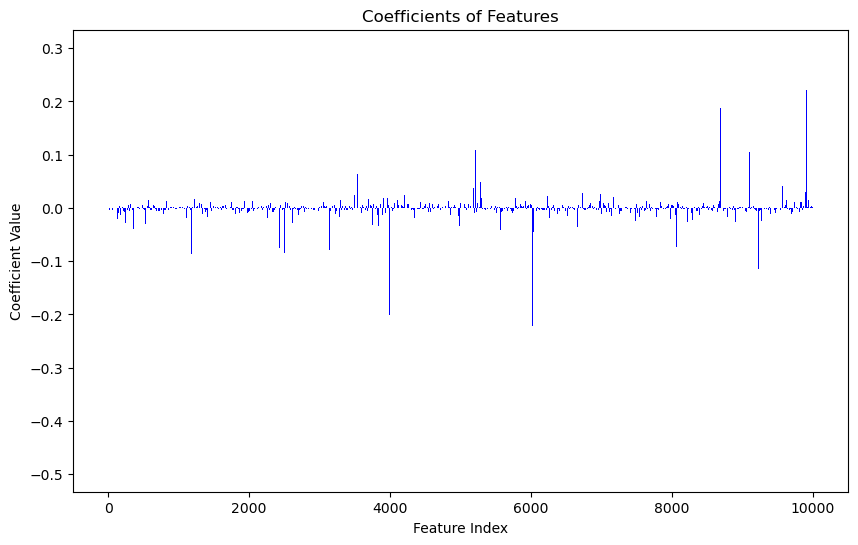

In [29]:
# Plotting coefficients
plt.figure(figsize=(10, 6))
plt.bar(range(len(coefficients)), coefficients, color='blue')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.title('Coefficients of Features')
plt.show()

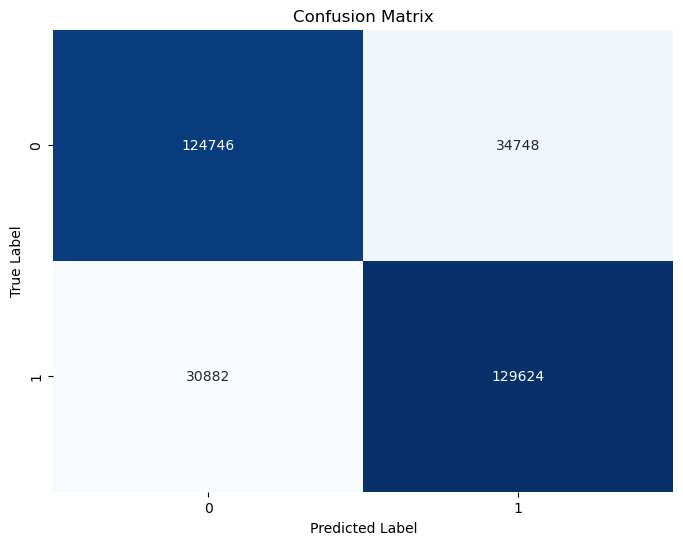

In [34]:
# Predictions on the test set
y_pred = grid_search.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

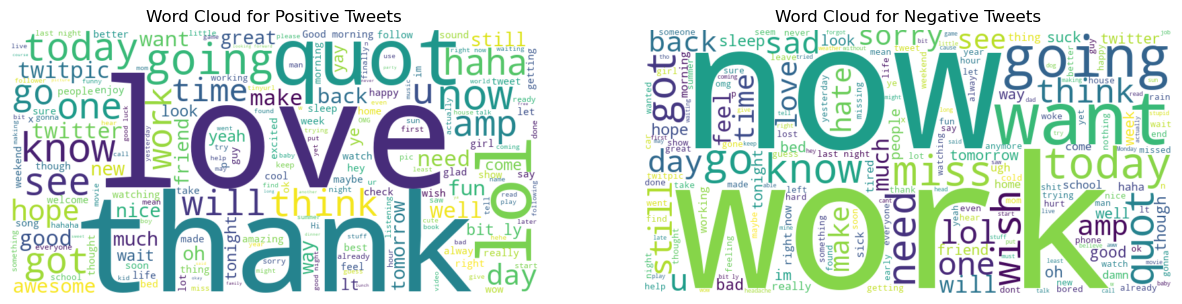

In [36]:
# Get positive and negative tweets
positive_tweets = df[df['sentiment'] == 4]['text']
negative_tweets = df[df['sentiment'] == 0]['text']

# Generate word clouds for positive and negative tweets
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_tweets))
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(negative_tweets))

# Plot word clouds
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Positive Tweets')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Negative Tweets')
plt.axis('off')

plt.show()